In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from load_data import FD001_dataset
from visualize_modified import visualize
from RUL_model import RUL_Model, RUL_Model_LearnableStates
from torch.utils.tensorboard import SummaryWriter
from typing import Optional, Tuple, List
from tqdm.auto import tqdm
from train_model import train_model, evaluate_data

# Check if MPS is available and built
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    # Fallback for systems with NVIDIA GPUs (though less relevant on a Mac)
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("MPS or CUDA not available, using CPU")

DATA_DIR_PATH = '../CMAPSSData/'

import plotly.express as px
import plotly.io as pio
# pio.templates.default = "none"
pio.templates.default = "plotly_dark"

RUL_UPPER_BOUND = 130  # UPPER BOUND OF RUL

/Users/neerajsohani/anaconda3/envs/lstm_rul_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Apple Silicon GPU)


In [2]:
# *** Define a padding index for labels ***
# This value MUST be ignored by your loss function.
# For nn.CrossEntropyLoss, use its 'ignore_index' parameter (default -100 is common).
# Choose a value that doesn't conflict with valid label indices/values.
LABEL_PADDING_IDX = -1000000

def pad_collate_fn_time_step_level(batch):
    sequences = [item[0] for item in batch]
    # Labels are also sequences now
    labels = [item[1] for item in batch] # e.g., list of tensors of shape [Li] or [Li, C]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long) # Lengths based on input sequences

    # Pad features (input sequences)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # *** Pad labels (label sequences) ***
    # Use the dedicated label padding index!
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=LABEL_PADDING_IDX)

    return padded_sequences, lengths, padded_labels

# Usage:
# train_loader = DataLoader(..., collate_fn=pad_collate_fn_time_step_level)

In [3]:
def plot_rul_vs_time(unit_nr, model, dataloader, device):
    """
    Plot the RUL over time for a given unit number.
    """
    X, true_rul = dataloader.dataset[unit_nr - 1]
    X = X.to(device)
    
    model.eval()
    predicted_rul = model(X).cpu().detach().numpy()

    fig = px.line(
        x=np.arange(1, len(true_rul) + 1),
        y=true_rul.reshape(-1),
        title=f'RUL Over Time: Unit {unit_nr}',
        labels={'x': 'Time', 'y': 'RUL'},
        markers=False
    )
    fig.add_scatter(
        x=np.arange(1, len(predicted_rul) + 1),
        y=predicted_rul.reshape(-1),
        mode='lines',
        name='Predicted RUL'
    )
    fig.update_layout(
        legend=dict(yanchor="bottom",
                    y=0.1,
                    xanchor="left",
                    x=0.1)
    )
    fig.show()
    

In [4]:
import re

def create_hparam_string(hparams):
  """
  Generates a concise file string representation from a hyperparameter dictionary.

  Args:
    hparams (dict): A dictionary containing hyperparameters.

  Returns:
    str: A formatted string summarizing the hyperparameters, suitable for filenames.
         Returns an empty string if the input is not a dictionary or is empty.
  """
  if not isinstance(hparams, dict) or not hparams:
    print("Warning: Input must be a non-empty dictionary.")
    return ""

  parts = []

  # Define abbreviations for keys to keep the string short
  abbreviations = {
      'LearningRate': 'LR',
      'BatchSize': 'BS',
      'HiddenSizes': 'HS',
      'LayerSizes': 'LS',
      'DropoutRate': 'DR',
      'LossFn': 'LF',
      'Optimizer': 'Opt',
      'LearnableStates': 'LrnS'
      # Add more abbreviations as needed
  }

  # Define the order in which parameters should appear in the string
  param_order = [
      'LearningRate', 'BatchSize', 'HiddenSizes', 'LayerSizes', 'DropoutRate',
      'LossFn', 'Optimizer', 'LearnableStates'
  ]

  for key in param_order:
      if key in hparams:
          value = hparams[key]
          abbr = abbreviations.get(key, key) # Use abbreviation if available, else full key

          # Format value based on its type
          if isinstance(value, list):
              # Join list elements with a hyphen
              value_str = '-'.join(map(str, value))
          elif isinstance(value, bool):
              # Use T/F for boolean values
              value_str = 'T' if value else 'F'
          elif isinstance(value, float):
              # Format float to avoid excessive decimal places and replace '.' with 'p'
              value_str = f"{value:.1e}".replace('.', 'p').replace('+','') # e.g., 0.001 -> 1e-03 -> 1e-03
          else:
              # Use string representation for other types
              value_str = str(value)

          # Sanitize value string for filename compatibility (remove potentially problematic characters)
          # Allows alphanumeric, hyphen, underscore, period
          # value_str = re.sub(r'[^\w\-._]+', '', value_str)

          parts.append(f"{abbr}_{value_str}")

  # Add any parameters from hparams that were not in param_order
  for key, value in hparams.items():
      if key not in param_order:
          abbr = abbreviations.get(key, key)
          if isinstance(value, bool):
              value_str = 'T' if value else 'F'
          elif isinstance(value, float):
              value_str = f"{value:.1e}".replace('.', 'p').replace('+','')
          else:
              value_str = str(value)
          # value_str = re.sub(r'[^\w\-._]+', '', value_str) # Sanitize
          parts.append(f"{abbr}_{value_str}")


  return '__'.join(parts)

In [85]:
train_dataset = FD001_dataset(data_type='train', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')
test_dataset = FD001_dataset(data_type='test', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')

train_dataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn_time_step_level)
test_dataLoader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=pad_collate_fn_time_step_level) 

<h2>Model Initialization and Training</h2>

In [6]:
# hparams = {
#     'LR': 0.001,
#     'BatchSize': 20,
#     'HiddenSizes': [32, 64],
#     'LayerSizes': [1, 1],
#     'DropoutRate': 0.3,
#     'LossFn': 'MSELoss',
#     'Optimizer': 'RMSprop',
#     'LearnableStates': True,
#     'device': device
# }
# hparams_str = create_hparam_string(hparams)
# model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
#                                   lstm_hidden_sizes=hparams['HiddenSizes'], 
#                                   lstm_layer_sizes=hparams['LayerSizes'], 
#                                   lstm_dropout_rate=hparams['DropoutRate'], 
#                                   output_dropout_rate=hparams['DropoutRate'], state_init=True)
# model.to(device)
# loss_fn = torch.nn.MSELoss(reduction='none')  # mean-squared error for regression
# # optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

# # Just to use the original visualisation module
# y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})


In [7]:

# writer = SummaryWriter(log_dir=f'runs/{hparams_str}')
# writer.add_graph(model, train_dataset[0][0].to(device))

# final_train_loss, best_val_loss, last_epoch = train_model(
#     model=model,
#     train_dataLoader=train_dataLoader, # Your training DataLoader
#     test_dataLoader=test_dataLoader,   # Your validation DataLoader
#     loss_fn=loss_fn,
#     optimizer=optimizer,
#     device=device,
#     writer=writer, # Pass your writer if using TensorBoard
#     num_epochs=1,
#     patience=10,
#     best_model_path=f'./models/best_model_{hparams_str}.pth', # Choose save path
#     y_test=y_test, # Optional: for visualization
# )

# # writer.add_hparams(hparam_dict=hparams, metric_dict={'Train Loss': train_loss,
# #                                                      'Validation Loss': val_loss,
# #                                                      'Num Epochs Run': epochs})

In [8]:
# rul_seqlen_err = list() # np.zeros((100, 3))
# model.eval()
# with torch.no_grad():
#     for i, (x, y) in enumerate(test_dataLoader):
#         y_pred = model(x)[:, -1, :].item()
#         true_rul = y[:, -1, :].item()
#         rul_err = true_rul - y_pred
#         rul_seqlen_err.append([true_rul, x.shape[1], rul_err])

# rul_seqlen_err = np.array(rul_seqlen_err).T
# rul_seqlen_err[2] = np.abs(rul_seqlen_err[2])

# px.scatter(
#     x=rul_seqlen_err[0],
#     y=rul_seqlen_err[1],
#     color=rul_seqlen_err[2],
#     title='True RUL vs Sequence Length',
#     labels={'x': 'True RUL', 'y': 'Sequence Length', 'color': 'RUL Error'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()
# px.scatter(
#     x=rul_seqlen_err[0],
#     y=rul_seqlen_err[2],
#     color=rul_seqlen_err[1],
#     title='True RUL vs RUL Error',
#     labels={'x': 'True RUL', 'y': 'RUL Error', 'color': 'Sequence Length'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()
# px.scatter(
#     x=rul_seqlen_err[1],
#     y=rul_seqlen_err[2],
#     color=rul_seqlen_err[0],
#     title='Sequence Length vs RUL Error',
#     labels={'x': 'Sequence Length', 'y': 'RUL Error', 'color': 'True RUL'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()

# # px.line(x=np.arange(1, len(true_rul) + 1), y=((true_rul - predicted_rul)).reshape(-1), title='RUL Error Over Time', labels={'x': 'Time', 'y': 'RUL Error'}, markers=False).show()

<h2>Cross Validation</h2>

In [9]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, random_split, ConcatDataset

In [10]:

hparams = {
    'LearningRate': 0.002,
    'BatchSize': 32,
    'HiddenSizes': [32, 64],
    'LayerSizes': [1, 1],
    'DropoutRate': 0.3,
    'LossFn': 'MSELoss',
    'Optimizer': 'RMSprop',
    'LearnableStates': False,
    'device': device,
    'CrossVal': 10
}
hparams_str = create_hparam_string(hparams)

# # Just to use the original visualisation module
# y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})

In [11]:
batch_size = hparams['BatchSize']
learning_rate = hparams['LearningRate']
learn_states = hparams['LearnableStates']
device = hparams['device']
hidden_sizes = hparams['HiddenSizes']
layer_sizes = hparams['LayerSizes']
dropout_rate = hparams['DropoutRate']

train_losses = []
val_losses = []
val_rmses_post_training = []
last_epochs = []

kfold = hparams['CrossVal']
kfold_frac = (1 / kfold)
dataset_split = random_split(train_dataset, [kfold_frac for _ in range(kfold)])

# ---- Fold Iteration for Cross Validation ----
for i in range(kfold):
    fold_str = hparams_str + f'__fold_{(i+1):02}'
    # ---- Create Validation and Train DataLoaders for current fold
    val_split = dataset_split[i]
    train_split = ConcatDataset([dataset_split[j] for j in range(kfold) if j != i])
    train_dataLoader = DataLoader(train_split, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn_time_step_level)
    val_dataLoader = DataLoader(val_split, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn_time_step_level) 
    
    # Just to use the original visualisation module
    # ----- HARD CODED -----
    y_test = pd.DataFrame({"RUL": [val_split[i][1][-1].item() for i in range(10)]})
    
    
    # ---- Create Model and send it to GPU if available ----
    if learn_states:
        model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
                                        lstm_hidden_sizes=hidden_sizes, 
                                        lstm_layer_sizes=layer_sizes, 
                                        lstm_dropout_rate=dropout_rate, 
                                        output_dropout_rate=dropout_rate)
    else:
        model = RUL_Model(input_size=train_dataLoader.dataset[0][0].shape[1],
                          lstm_hidden_sizes=hidden_sizes,
                          lstm_layer_sizes=layer_sizes,
                          lstm_dropout_rate=dropout_rate,
                          output_dropout_rate=dropout_rate)
    model.to(device)
    
    # ---- Create Loss Function and Optimizer Instances ----
    loss_fn = torch.nn.MSELoss(reduction='none')
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # ---- Create SummaryWriter for TensorBoard Visualisation ----
    writer = SummaryWriter(log_dir=f'runs/{fold_str}')
    writer.add_graph(model, train_dataset[0][0].to(device))

    # ---- Train Model for this fold and save the final metrics ----
    final_train_loss, best_val_loss, val_rmse_post_training, last_epoch = train_model(
        model=model,
        train_dataLoader=train_dataLoader, # Your training DataLoader
        test_dataLoader=val_dataLoader,   # Your validation DataLoader
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        writer=writer, # Pass your writer if using TensorBoard
        num_epochs=250,
        y_test=y_test,
        patience=10,
        best_model_path=f'./models/best_model_{fold_str}.pth', # Choose save path
        compare_entire_seq_in_val=True
    )
    train_losses.append(final_train_loss)
    val_losses.append(best_val_loss)
    val_rmses_post_training.append(val_rmse_post_training)
    last_epochs.append(last_epoch)
    
    # ---- Log Hyperparameters and final metrics for current fold's run ----
    # TODO: need to create valid hparams dict to pass to writer
    # writer.add_hparams(hparam_dict=hparams,
    #                    metric_dict={})

Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9614.6629 | Val Loss: 103.9666
Validation RMSE improved (inf --> 103.9666). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9456.8731 | Val Loss: 102.3902
Validation RMSE improved (103.9666 --> 102.3902). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9111.1203 | Val Loss: 99.9790
Validation RMSE improved (102.3902 --> 99.9790). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8633.4367 | Val Loss: 96.9470
Validation RMSE improved (99.9790 --> 96.9470). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8075.5490 | Val Loss: 93.6847
Validation RMSE improved (96.9470 --> 93.6847). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7514.2018 | Val Loss: 89.9737
Validation RMSE improved (93.6847 --> 89.9737). Saving model...
Epoch   7/250 | Training... 96 | Train Loss (avg/element): 689

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 53. Best Validation RMSE: 20.0211. Validation RMSE (Last Step): 3.1458.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9858.8167 | Val Loss: 95.6975
Validation RMSE improved (inf --> 95.6975). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9674.2213 | Val Loss: 93.8920
Validation RMSE improved (95.6975 --> 93.8920). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9263.0481 | Val Loss: 91.3752
Validation RMSE improved (93.8920 --> 91.3752). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8752.0276 | Val Loss: 88.3193
Validation RMSE improved (91.3752 --> 88.3193). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8158.8064 | Val Loss: 84.8364
Validation RMSE improved (88.3193 --> 84.8364). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7551.9066 | Val Loss: 81.0867
Validation RMSE improved (84.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 64. Best Validation RMSE: 16.0880. Validation RMSE (Last Step): 5.4963.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9737.7345 | Val Loss: 96.8761
Validation RMSE improved (inf --> 96.8761). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9261.4336 | Val Loss: 92.7922
Validation RMSE improved (96.8761 --> 92.7922). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8413.5431 | Val Loss: 87.6636
Validation RMSE improved (92.7922 --> 87.6636). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 7447.8658 | Val Loss: 81.3724
Validation RMSE improved (87.6636 --> 81.3724). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 6422.2867 | Val Loss: 75.0115
Validation RMSE improved (81.3724 --> 75.0115). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 5504.8425 | Val Loss: 68.8498
Validation RMSE improved (75.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 48. Best Validation RMSE: 16.4540. Validation RMSE (Last Step): 8.5745.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9660.1880 | Val Loss: 99.1151
Validation RMSE improved (inf --> 99.1151). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9417.5634 | Val Loss: 97.3727
Validation RMSE improved (99.1151 --> 97.3727). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9074.5896 | Val Loss: 95.4402
Validation RMSE improved (97.3727 --> 95.4402). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8699.8037 | Val Loss: 93.1746
Validation RMSE improved (95.4402 --> 93.1746). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8283.6328 | Val Loss: 90.6918
Validation RMSE improved (93.1746 --> 90.6918). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7840.1785 | Val Loss: 88.0553
Validation RMSE improved (90.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 77. Best Validation RMSE: 22.4889. Validation RMSE (Last Step): 3.0537.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9763.3400 | Val Loss: 95.1044
Validation RMSE improved (inf --> 95.1044). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9530.8264 | Val Loss: 93.2076
Validation RMSE improved (95.1044 --> 93.2076). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9116.8836 | Val Loss: 90.6575
Validation RMSE improved (93.2076 --> 90.6575). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8610.0134 | Val Loss: 87.6714
Validation RMSE improved (90.6575 --> 87.6714). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8046.7509 | Val Loss: 84.2781
Validation RMSE improved (87.6714 --> 84.2781). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7438.8033 | Val Loss: 80.5698
Validation RMSE improved (84.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 88. Best Validation RMSE: 16.3911. Validation RMSE (Last Step): 3.2932.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9736.6741 | Val Loss: 98.7739
Validation RMSE improved (inf --> 98.7739). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9292.3815 | Val Loss: 95.1159
Validation RMSE improved (98.7739 --> 95.1159). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8528.6735 | Val Loss: 90.4029
Validation RMSE improved (95.1159 --> 90.4029). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 7660.0355 | Val Loss: 85.1190
Validation RMSE improved (90.4029 --> 85.1190). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 6771.2465 | Val Loss: 79.6829
Validation RMSE improved (85.1190 --> 79.6829). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 5949.9095 | Val Loss: 73.9950
Validation RMSE improved (79.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 56. Best Validation RMSE: 15.4217. Validation RMSE (Last Step): 3.6633.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9763.5739 | Val Loss: 95.5054
Validation RMSE improved (inf --> 95.5054). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9717.8462 | Val Loss: 94.8479
Validation RMSE improved (95.5054 --> 94.8479). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9541.7667 | Val Loss: 93.7817
Validation RMSE improved (94.8479 --> 93.7817). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 9337.1682 | Val Loss: 92.6793
Validation RMSE improved (93.7817 --> 92.6793). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 9115.6682 | Val Loss: 91.4527
Validation RMSE improved (92.6793 --> 91.4527). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8875.4372 | Val Loss: 90.1388
Validation RMSE improved (91.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 93. Best Validation RMSE: 20.0156. Validation RMSE (Last Step): 6.1814.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9660.3531 | Val Loss: 100.1592
Validation RMSE improved (inf --> 100.1592). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9468.5310 | Val Loss: 98.3501
Validation RMSE improved (100.1592 --> 98.3501). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9093.2312 | Val Loss: 96.1000
Validation RMSE improved (98.3501 --> 96.1000). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8660.3957 | Val Loss: 93.5577
Validation RMSE improved (96.1000 --> 93.5577). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8183.5972 | Val Loss: 90.7785
Validation RMSE improved (93.5577 --> 90.7785). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7707.7349 | Val Loss: 87.5661
Validation RMSE improved (

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 88. Best Validation RMSE: 13.4225. Validation RMSE (Last Step): 2.9121.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9744.6155 | Val Loss: 95.4871
Validation RMSE improved (inf --> 95.4871). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9514.8757 | Val Loss: 93.8610
Validation RMSE improved (95.4871 --> 93.8610). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9188.6003 | Val Loss: 92.0960
Validation RMSE improved (93.8610 --> 92.0960). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8841.7685 | Val Loss: 90.1515
Validation RMSE improved (92.0960 --> 90.1515). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8479.5125 | Val Loss: 88.0603
Validation RMSE improved (90.1515 --> 88.0603). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8088.0567 | Val Loss: 85.8092
Validation RMSE improved (88.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 74. Best Validation RMSE: 16.9927. Validation RMSE (Last Step): 3.9247.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9699.5766 | Val Loss: 95.1658
Validation RMSE improved (inf --> 95.1658). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9014.5428 | Val Loss: 89.5635
Validation RMSE improved (95.1658 --> 89.5635). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 7897.6418 | Val Loss: 82.7469
Validation RMSE improved (89.5635 --> 82.7469). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 6754.1636 | Val Loss: 75.6461
Validation RMSE improved (82.7469 --> 75.6461). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 5717.3070 | Val Loss: 69.0144
Validation RMSE improved (75.6461 --> 69.0144). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 4855.2538 | Val Loss: 63.0924
Validation RMSE improved (69.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 60. Best Validation RMSE: 16.7923. Validation RMSE (Last Step): 4.2099.


In [ ]:
#### MODEL METRICS WITH LEARNABLE STATES
avg_train_loss = np.mean(np.array(train_losses))
avg_val_loss = np.mean(val_losses)
avg_val_rmse = np.mean(val_rmse_post_training)

print(f"Average Train Loss = {avg_train_loss}")
print(f"Average Val RMSE (Entire Sequence) = {avg_val_loss}")
print(f"Average Val RMSE (Last Step) = {avg_val_rmse}")

Average Train Loss = 1334.2834912575292
Average Val RMSE (Entire Sequence) = 17.494064212141318
Average Val RMSE (Last Step) = 5.061805507919086


In [12]:
#### MODEL METRICS NO LEARNABLE STATES
avg_train_loss = np.mean(np.array(train_losses))
avg_val_loss = np.mean(val_losses)
avg_val_rmse = np.mean(val_rmse_post_training)

print(f"Average Train Loss = {avg_train_loss}")
print(f"Average Val RMSE (Entire Sequence) = {avg_val_loss}")
print(f"Average Val RMSE (Last Step) = {avg_val_rmse}")

Average Train Loss = 1287.8975687910302
Average Val RMSE (Entire Sequence) = 17.408794744149542
Average Val RMSE (Last Step) = 4.209917693069768


/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_58237/3911503587.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

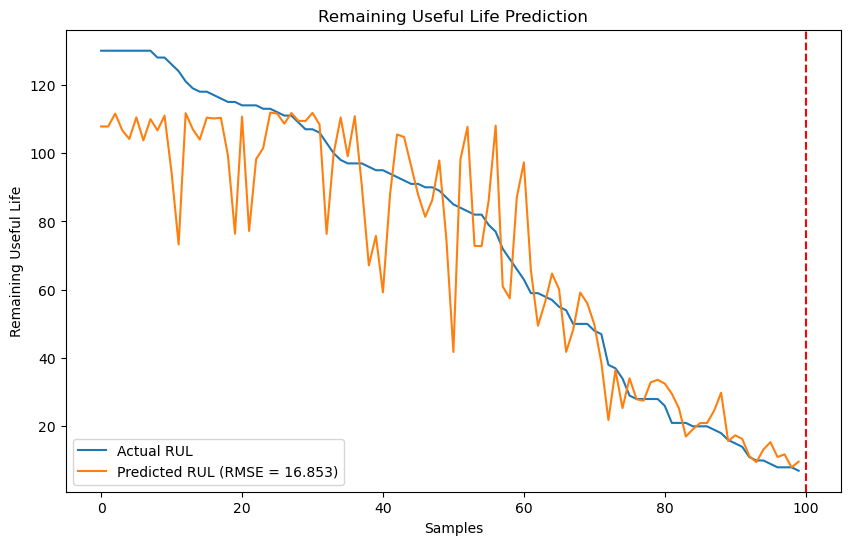

In [13]:
batch_size = hparams['BatchSize']
learning_rate = hparams['LearningRate']
learn_states = hparams['LearnableStates']
device = hparams['device']
hidden_sizes = hparams['HiddenSizes']
layer_sizes = hparams['LayerSizes']
dropout_rate = hparams['DropoutRate']

# ---- Create Model and send it to GPU if available ----
if learn_states:
    model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
                                    lstm_hidden_sizes=hidden_sizes, 
                                    lstm_layer_sizes=layer_sizes, 
                                    lstm_dropout_rate=dropout_rate, 
                                    output_dropout_rate=dropout_rate)
else:
    model = RUL_Model(input_size=train_dataLoader.dataset[0][0].shape[1],
                        lstm_hidden_sizes=hidden_sizes,
                        lstm_layer_sizes=layer_sizes,
                        lstm_dropout_rate=dropout_rate,
                        output_dropout_rate=dropout_rate)
model.to(device)

loss_fn = torch.nn.MSELoss(reduction='none')

test_rmse_list = []
test_pred_list_for_all_folds = []

for fold in range(1, hparams['CrossVal'] + 1):
    model_path = './models/best_model_' + hparams_str + f'__fold_{(fold):02}.pth'
    
    # ---- Load Best Model for the fold ----
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    test_rmse, test_pred_list = evaluate_data(model=model,
                                              dataLoader=test_dataLoader,
                                              loss_fn=loss_fn,
                                              device=device,
                                              compare_entire_seq=False)
    test_rmse_list.append(test_rmse)
    test_pred_list_for_all_folds.append(test_pred_list)

# ---- Calculate Average RMSE and Predictions across all folds ----
test_pred_arr = np.array(test_pred_list_for_all_folds).squeeze()
test_rmse_arr = np.array(test_rmse_list)

avg_test_preds = np.mean(test_pred_arr, axis=0)
avg_test_rmse = np.mean(test_rmse_arr)

# ---- Visualize RUL vs Sorted Unit Samples ----
y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})

visualize(avg_test_preds, y_test, 100, avg_test_rmse, None)

In [90]:
plot_rul_vs_time(unit_nr=10, model=model, dataloader=train_dataLoader, device=device)

In [78]:
lens = []
for i in range(100):
    lens.append(train_dataset[i][0].size(0))

In [71]:
rul_seqlen_err = list() # np.zeros((100, 3))
model.eval()
with torch.no_grad():
    for i in range(100):
        X, y = test_dataset[i]
        X = X.to(device)
        y_pred = model(X).cpu().detach()
        max_seq_len = X.size(0)
        for t in range(max_seq_len):
            true_rul = y[t, :].item()
            rul_err = true_rul - y_pred[t, :].item()
            rul_seqlen_err.append([true_rul, (t+1), rul_err])
rul_seqlen_err = np.array(rul_seqlen_err).T
rul_seqlen_err[2] = np.log2(np.abs(rul_seqlen_err[2]))
# rul_seqlen_err[2] = np.abs(rul_seqlen_err[2])

px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    color=rul_seqlen_err[2],
    title='True RUL vs Sequence Length',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'color': 'RUL Error (log2)'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[1],
    title='True RUL vs RUL Error (log2)',
    labels={'x': 'True RUL', 'y': 'RUL Error (log2)', 'color': 'Sequence Length'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()
px.scatter(
    x=rul_seqlen_err[1],
    y=rul_seqlen_err[2],
    color=rul_seqlen_err[0],
    title='Sequence Length vs RUL Error (log2)',
    labels={'x': 'Sequence Length', 'y': 'RUL Error (log2)', 'color': 'True RUL'},
    color_continuous_scale=px.colors.sequential.Viridis
).show()

# px.line(x=np.arange(1, len(true_rul) + 1), y=((true_rul - predicted_rul)).reshape(-1), title='RUL Error Over Time', labels={'x': 'Time', 'y': 'RUL Error'}, markers=False).show()

In [72]:
fig = px.scatter_3d(
    x=rul_seqlen_err[0],
    y=rul_seqlen_err[1],
    z=rul_seqlen_err[2],
    title='3D Scatter Plot of True RUL, Sequence Length, and RUL Error (log2)',
    labels={'x': 'True RUL', 'y': 'Sequence Length', 'z': 'RUL Error (log2)', 'color': 'RUL Error (log2)'},
    color=rul_seqlen_err[2],
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700
)
fig.show()

In [73]:
corr_matrix = np.corrcoef(rul_seqlen_err, rowvar=True)

# print(f"Correlation Matrix:\n{corr_matrix}\n")
# print(f"Pairwise correlation r(Y, X1): {corr_matrix[0, 1]:.4f}")
print(f"Pairwise correlation r(True_RUL, log2_RUL_Error): {corr_matrix[0, 2]:.4f}")
print(f"Pairwise correlation r(Sequence_len, log2_RUL_Error): {corr_matrix[1, 2]:.4f}")
print("\n")

Pairwise correlation r(True_RUL, log2_RUL_Error): 0.5187
Pairwise correlation r(Sequence_len, log2_RUL_Error): -0.2913




<h2>Make Sure the model is using the entire time history and not just the current state</h2>

In [29]:
"""
Computes the predictions for a given unit,
i.e., a given sequence of sensor data, in the standard way.
You give the entire sequence all at once and get a output array
with prediction for each time step. Ideally the prediction at time step t should
depend on the sensor data from all previous time steps.
"""
model.eval()
predictions_all_at_once = []
for i in range(100):
    X, _ = test_dataset[i]
    X = X.to(device)
    predictions_all_at_once.append(model(X).cpu().detach().numpy())  # forward pass

In [36]:
"""
Computes the predictions for a given all time steps one at a time,
i.e., the model is called for each time step to get the prediction for that time step.
This ensures that the model is getting any past information for the prediction.
"""
model.eval()
predictions_one_at_a_time = []
for i in range(100):
    X, _ = test_dataset[i]
    X = X.to(device)
    output = []
    for i in range(X.size(0)):
        X_t = X[i:i+1, :]
        tmp = model(X_t).cpu().detach().numpy()
        output.append(tmp)  # forward pass
    # get the last prediction
    # X = unit_X.iloc[-1:, :]
    # X_train_tensors = Variable(torch.Tensor(X.to_numpy()))
    # X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    # output.append(model(X_train_tensors).detach().numpy().squeeze())  # forward pass
    output = np.array(output)
    output = output.reshape(-1, 1)
    predictions_one_at_a_time.append(output)  # forward pass

In [42]:
"""
Compares the two predictions for each time step for each unit.
"""
num_units_with_diff = 0
for unit_nr in range(1, 101):
    a, b = predictions_all_at_once[unit_nr - 1], predictions_one_at_a_time[unit_nr - 1]
    c = a - b
    stats = (max(c).item(), min(c).item())
    if stats[0] != 0 or stats[1] != 0:
        num_units_with_diff += 1
        print(f"Unit {unit_nr}: Max: {stats[0]}, Min: {stats[1]}")
print(f"Number of units with different predictions: {num_units_with_diff}")

Unit 1: Max: 35.323394775390625, Min: 0.0
Unit 2: Max: 71.79389190673828, Min: 0.0
Unit 3: Max: 93.45426940917969, Min: 0.0
Unit 4: Max: 82.03103637695312, Min: 0.0
Unit 5: Max: 91.95232391357422, Min: 0.0
Unit 6: Max: 82.49847412109375, Min: 0.0
Unit 7: Max: 36.549354553222656, Min: 7.62939453125e-06
Unit 8: Max: 89.94123840332031, Min: 0.0
Unit 9: Max: 79.77165222167969, Min: 0.0
Unit 10: Max: 34.66285705566406, Min: -7.358551025390625
Unit 11: Max: 92.5748291015625, Min: 0.0
Unit 12: Max: 34.56721496582031, Min: 0.0
Unit 13: Max: 37.61853790283203, Min: -3.9832000732421875
Unit 14: Max: 96.23320770263672, Min: 0.0
Unit 15: Max: 37.13439178466797, Min: 0.0
Unit 16: Max: 37.47428894042969, Min: 0.0
Unit 17: Max: 51.362998962402344, Min: -7.8596649169921875
Unit 18: Max: 37.85187530517578, Min: -11.15311050415039
Unit 19: Max: 35.65428924560547, Min: 0.0
Unit 20: Max: 80.01361846923828, Min: 0.0
Unit 21: Max: 36.46569061279297, Min: 0.0
Unit 22: Max: 59.49309539794922, Min: 0.0
Unit 23

<p>All good! The model considers the entire history of inputs.</p>